# Markov Decision Process

State transition is defined by $P(s' |s,a)$ - how likely are you to end at state $s'$ if you take action $a$ from state $s$. Now there's more than one way to define rewards, but we'll use $r(s,a,s')$ function for convenience.

In [4]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

We can now use MDP just as any other gym environment:

In [5]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


but it also has other methods that you'll need for Value Iteration

In [6]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


### Visualizing MDPs

You have to install graphviz for system and for python.

1. * For ubuntu just run: `sudo apt-get install graphviz`
   * For OSX: `brew install graphviz`
2. `pip install graphviz`
3. restart the notebook

__Note:__ Installing graphviz on some OS (esp. Windows) may be tricky. However, you can ignore this part alltogether and use the standart vizualization.

In [7]:
from mdp import has_graphviz
from IPython.display import display
print("Graphviz available:", has_graphviz)

Graphviz available: False


In [14]:
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
    display(plot_graph(mdp))

# 1. Value Iteration (VI)

Now let's build something to solve this MDP. The simplest algorithm so far is __V__alue __I__teration

Here's the pseudo-code for VI:

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$

`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

---

First, let's write a function to compute the state-action value function $Q^{\pi}$, defined as follows

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$

In [15]:
def get_action_value(mdp, state_values, state, action, gamma):
    """ Computes Q(s,a) as in formula above """

    def calc_q_value(probability, reward, state):
        return probability * (reward + gamma * state_values[state])

    next_states = mdp.get_next_states(state, action)
    Q = 0

    for st in next_states:
        Q += calc_q_value(probability=next_states[st],
                          reward=mdp.get_reward(state, action, st),
                          state=st)

    return Q

In [16]:
import numpy as np
test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.isclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.isclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

Using $Q(s,a)$ we can now define the "next" V(s) for value iteration.
 $$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [17]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Computes next V(s) as in formula above. Please do not change state_values in process. """
    if mdp.is_terminal(state):
        return 0

    actions, st_val = mdp.get_possible_actions(state), 0
    for act in actions:
        act_val = get_action_value(mdp, state_values, state, act, gamma)
        if act_val > st_val:
            st_val = act_val

    return st_val

In [18]:
test_Vs_copy = dict(test_Vs)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 1.08)
assert test_Vs == test_Vs_copy, "Please do not change state_values in get_new_state_value"

In [19]:
# parameters
gamma = 0.9            # discount for MDP
num_iter = 100         # maximum iterations, excluding initialization
# stop VI if new values are this close to old values (or closer)
min_difference = 0.001

# initialize V(s)
state_values = {s: 0 for s in mdp.get_all_states()}
new_state_values = {}

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

for i in range(num_iter):
    # Compute new state values using the functions you defined above.
    # It must be a dict {state : float V_new(state)}
    for s in state_values:
        new_state_values[s] = get_new_state_value(mdp,state_values,s,gamma)

    assert isinstance(new_state_values, dict)

    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    print("iter %4i   |   diff: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = dict(new_state_values)

    if diff < min_difference:
        print("Terminated")
        break

iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000
iter    1   |   diff: 0.64500   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000
iter    2   |   diff: 0.58050   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 0.645
iter    3   |   diff: 0.43582   |   V(s0) = 0.581   V(s1) = 3.959   V(s2) = 0.962
iter    4   |   diff: 0.30634   |   V(s0) = 0.866   V(s1) = 4.395   V(s2) = 1.272
iter    5   |   diff: 0.27571   |   V(s0) = 1.145   V(s1) = 4.670   V(s2) = 1.579
iter    6   |   diff: 0.24347   |   V(s0) = 1.421   V(s1) = 4.926   V(s2) = 1.838
iter    7   |   diff: 0.21419   |   V(s0) = 1.655   V(s1) = 5.169   V(s2) = 2.075
iter    8   |   diff: 0.19277   |   V(s0) = 1.868   V(s1) = 5.381   V(s2) = 2.290
iter    9   |   diff: 0.17327   |   V(s0) = 2.061   V(s1) = 5.573   V(s2) = 2.481
iter   10   |   diff: 0.15569   |   V(s0) = 2.233   V(s1) = 5.746   V(s2) = 2.654
iter   11   |   diff: 0.14012   |   V(s0) = 2.389   V(s1) = 5.902   V(s2) = 2.810
iter   12   |   

In [20]:
if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

In [21]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 3.781) < 0.01
assert abs(state_values['s1'] - 7.294) < 0.01
assert abs(state_values['s2'] - 4.202) < 0.01

Final state values: {'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}


Now let's use those $V^{*}(s)$ to find optimal actions in each state

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$

The only difference vs V(s) is that here we take not max but argmax: find action such with maximum Q(s,a).

In [22]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state):
        return None

    actions = mdp.get_possible_actions(state)
    opt_act, opt_act_val = None, -float("inf")
    for action in actions:
        act_val = get_action_value(mdp, state_values, state, action, gamma)
        if act_val >= opt_act_val:
            opt_act_val = act_val
            opt_act = action

    return opt_act

In [23]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a1'

assert get_optimal_action(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9) == 'a0', \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert get_optimal_action(mdp, {'s0': -2e10, 's1': 0, 's2': -1e10}, 's0', 0.9) == 'a1', \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"

In [24]:
if has_graphviz:
    display(plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value))

In [25]:
# Measure agent's average reward

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("average reward: ", np.mean(rewards))

assert(0.40 < np.mean(rewards) < 0.55)

average reward:  0.4347


### Frozen lake

In [26]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [27]:
def value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ performs num_iter value iteration steps starting from state_values. Same as before but in a function """
    state_values = state_values or {s: 0 for s in mdp.get_all_states()}
    new_state_values = {}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        for s in state_values:
            new_state_values[s] = get_new_state_value(mdp,state_values,s,gamma)

        assert isinstance(new_state_values, dict)

        # Compute difference
        diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())

        print("iter %4i   |   diff: %6.8f   |   V(start): %.3f " %
              (i, diff, new_state_values[mdp._initial_state]))

        state_values = dict(new_state_values)
        if diff < min_difference:
            break

    return state_values

In [28]:
state_values = value_iteration(mdp)

iter    0   |   diff: 1.00000000   |   V(start): 0.000 
iter    1   |   diff: 0.90000000   |   V(start): 0.000 
iter    2   |   diff: 0.81000000   |   V(start): 0.000 
iter    3   |   diff: 0.72900000   |   V(start): 0.000 
iter    4   |   diff: 0.65610000   |   V(start): 0.000 
iter    5   |   diff: 0.59049000   |   V(start): 0.590 
iter    6   |   diff: 0.00000000   |   V(start): 0.590 


In [29]:
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break

*FFF
FHFH
FFFH
HFFG

right

S*FF
FHFH
FFFH
HFFG

right

SF*F
FHFH
FFFH
HFFG

down

SFFF
FH*H
FFFH
HFFG

down

SFFF
FHFH
FF*H
HFFG

down

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FFFH
HFF*



### Let's visualize!

It's usually interesting to see what your algorithm actually learned under the hood. To do so, we'll plot state value functions and optimal actions at each VI step.

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline


def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (0, 1)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(x, y, u*.3, -v*.3, color='m',
                      head_width=0.1, head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

after iteration 0
iter    0   |   diff: 1.00000000   |   V(start): 0.000 


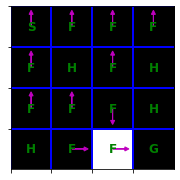

after iteration 1
iter    0   |   diff: 0.90000000   |   V(start): 0.000 


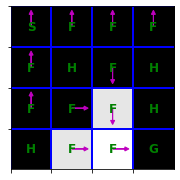

after iteration 2
iter    0   |   diff: 0.81000000   |   V(start): 0.000 


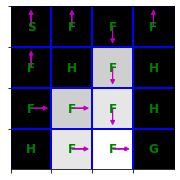

after iteration 3
iter    0   |   diff: 0.72900000   |   V(start): 0.000 


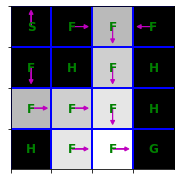

after iteration 4
iter    0   |   diff: 0.65610000   |   V(start): 0.000 


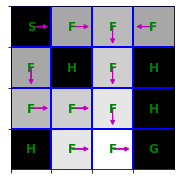

after iteration 5
iter    0   |   diff: 0.59049000   |   V(start): 0.590 


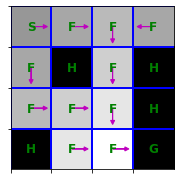

after iteration 6
iter    0   |   diff: 0.00000000   |   V(start): 0.590 


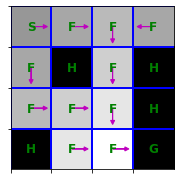

after iteration 7
iter    0   |   diff: 0.00000000   |   V(start): 0.590 


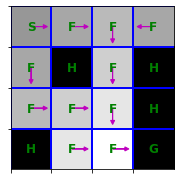

after iteration 8
iter    0   |   diff: 0.00000000   |   V(start): 0.590 


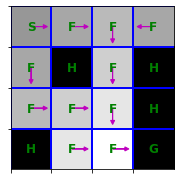

after iteration 9
iter    0   |   diff: 0.00000000   |   V(start): 0.590 


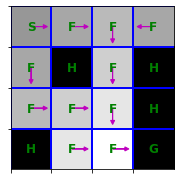

In [31]:
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(10):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# please ignore iter 0 at each step

after iteration 29
iter    0   |   diff: 0.00000008   |   V(start): 0.198 


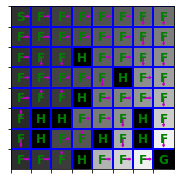

In [32]:
from IPython.display import clear_output
from time import sleep
mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.1)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step

In [33]:
mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Well done!")

iter    0   |   diff: 1.00000000   |   V(start): 0.000 
iter    1   |   diff: 0.90000000   |   V(start): 0.000 
iter    2   |   diff: 0.81000000   |   V(start): 0.000 
iter    3   |   diff: 0.72900000   |   V(start): 0.000 
iter    4   |   diff: 0.65610000   |   V(start): 0.000 
iter    5   |   diff: 0.59049000   |   V(start): 0.590 
iter    6   |   diff: 0.00000000   |   V(start): 0.590 
average reward:  1.0
Well done!


In [34]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Well done!")

iter    0   |   diff: 0.90000000   |   V(start): 0.000 
iter    1   |   diff: 0.72900000   |   V(start): 0.000 
iter    2   |   diff: 0.62329500   |   V(start): 0.000 
iter    3   |   diff: 0.50486895   |   V(start): 0.000 
iter    4   |   diff: 0.40894385   |   V(start): 0.000 
iter    5   |   diff: 0.34867844   |   V(start): 0.349 
iter    6   |   diff: 0.06529004   |   V(start): 0.410 
iter    7   |   diff: 0.05832170   |   V(start): 0.468 
iter    8   |   diff: 0.01139391   |   V(start): 0.480 
iter    9   |   diff: 0.00763656   |   V(start): 0.487 
iter   10   |   diff: 0.00164055   |   V(start): 0.489 
iter   11   |   diff: 0.00093749   |   V(start): 0.490 
iter   12   |   diff: 0.00021804   |   V(start): 0.490 
iter   13   |   diff: 0.00011290   |   V(start): 0.490 
iter   14   |   diff: 0.00002806   |   V(start): 0.490 
iter   15   |   diff: 0.00001353   |   V(start): 0.490 
iter   16   |   diff: 0.00000355   |   V(start): 0.490 
average reward:  0.878
Well done!


In [35]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Well done!")

iter    0   |   diff: 0.75000000   |   V(start): 0.000 
iter    1   |   diff: 0.50625000   |   V(start): 0.000 
iter    2   |   diff: 0.39867188   |   V(start): 0.000 
iter    3   |   diff: 0.26910352   |   V(start): 0.000 
iter    4   |   diff: 0.18164487   |   V(start): 0.000 
iter    5   |   diff: 0.14012604   |   V(start): 0.140 
iter    6   |   diff: 0.07028197   |   V(start): 0.199 
iter    7   |   diff: 0.06029799   |   V(start): 0.260 
iter    8   |   diff: 0.02593700   |   V(start): 0.285 
iter    9   |   diff: 0.01917967   |   V(start): 0.305 
iter   10   |   diff: 0.00857972   |   V(start): 0.313 
iter   11   |   diff: 0.00559586   |   V(start): 0.319 
iter   12   |   diff: 0.00259788   |   V(start): 0.321 
iter   13   |   diff: 0.00158617   |   V(start): 0.323 
iter   14   |   diff: 0.00075952   |   V(start): 0.324 
iter   15   |   diff: 0.00044531   |   V(start): 0.324 
iter   16   |   diff: 0.00021854   |   V(start): 0.324 
iter   17   |   diff: 0.00012469   |   V(start):

In [36]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Well done!")

iter    0   |   diff: 0.80000000   |   V(start): 0.000 
iter    1   |   diff: 0.57600000   |   V(start): 0.000 
iter    2   |   diff: 0.41472000   |   V(start): 0.000 
iter    3   |   diff: 0.29859840   |   V(start): 0.000 
iter    4   |   diff: 0.24186470   |   V(start): 0.000 
iter    5   |   diff: 0.19349176   |   V(start): 0.000 
iter    6   |   diff: 0.15324548   |   V(start): 0.000 
iter    7   |   diff: 0.12287501   |   V(start): 0.000 
iter    8   |   diff: 0.09930307   |   V(start): 0.000 
iter    9   |   diff: 0.08037455   |   V(start): 0.000 
iter   10   |   diff: 0.06426064   |   V(start): 0.000 
iter   11   |   diff: 0.05129035   |   V(start): 0.000 
iter   12   |   diff: 0.04330375   |   V(start): 0.000 
iter   13   |   diff: 0.03802251   |   V(start): 0.033 
iter   14   |   diff: 0.03331571   |   V(start): 0.058 
iter   15   |   diff: 0.02909504   |   V(start): 0.087 
iter   16   |   diff: 0.01855421   |   V(start): 0.106 
iter   17   |   diff: 0.01403179   |   V(start):

In [37]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.6, 's1': 0.1, 's2': 0.3},
        'a1': {'s1': 0.91, 's2': 0.09}
    },
    's2': {
        'a0': {'s0': 0.2, 's1': 0.8},
        'a1': {'s0': 0.4, 's1': 0.4, 's2': 0.2}
    }
}
rewards = {
    's1': {'a0': {'s0': +7}},
    's2': {'a1': {'s0': -2}}
}

from mdp import MDP
from numpy import random
mdp = MDP(transition_probs, rewards, initial_state=random.choice(tuple(transition_probs.keys())))
# Feel free to change the initial_state

In [38]:
state_values = {s: 0 for s in mdp.get_all_states()}
policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                   for state in sorted(mdp.get_all_states())])

for i in range(100):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)

    new_policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                           for state in sorted(mdp.get_all_states())])

    n_changes = (policy != new_policy).sum()
    print("N actions changed = %i \n" % n_changes)
    policy = new_policy

# please ignore iter 0 at each step

after iteration 0
iter    0   |   diff: 4.20000000   |   V(start): 0.000 
N actions changed = 0 

after iteration 1
iter    0   |   diff: 3.02400000   |   V(start): 0.000 
N actions changed = 0 

after iteration 2
iter    0   |   diff: 2.72160000   |   V(start): 2.722 
N actions changed = 0 

after iteration 3
iter    0   |   diff: 1.61969220   |   V(start): 2.967 
N actions changed = 0 

after iteration 4
iter    0   |   diff: 1.21026830   |   V(start): 3.959 
N actions changed = 0 

after iteration 5
iter    0   |   diff: 1.08924147   |   V(start): 5.048 
N actions changed = 0 

after iteration 6
iter    0   |   diff: 0.85434030   |   V(start): 5.582 
N actions changed = 0 

after iteration 7
iter    0   |   diff: 0.76890627   |   V(start): 6.350 
N actions changed = 0 

after iteration 8
iter    0   |   diff: 0.65604343   |   V(start): 6.975 
N actions changed = 0 

after iteration 9
iter    0   |   diff: 0.58479521   |   V(start): 7.484 
N actions changed = 0 

after iteration 10
i

### Value iteration convervence proof (1 pts)
**Note:** Assume that $\mathcal{S}, \mathcal{A}$ are finite.

Update of value function in value iteration can be rewritten in a form of Bellman operator:

$$(TV)(s) = \max_{a \in \mathcal{A}}\mathbb{E}\left[ r_{t+1} + \gamma V(s_{t+1}) | s_t = s, a_t = a\right]$$

Value iteration algorithm with Bellman operator:

---
&nbsp;&nbsp; Initialize $V_0$

&nbsp;&nbsp; **for** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; $V_{k+1} \leftarrow TV_k$

&nbsp;&nbsp;**end for**

---

In [lecture](https://docs.google.com/presentation/d/1lz2oIUTvd2MHWKEQSH8hquS66oe4MZ_eRvVViZs2uuE/edit#slide=id.g4fd6bae29e_2_4) we established contraction property of bellman operator:

$$
||TV - TU||_{\infty} \le \gamma ||V - U||_{\infty}
$$

For all $V, U$

Using contraction property of Bellman operator, Banach fixed-point theorem and Bellman equations prove that value function converges to $V^*$ in value iterateion$

*<-- Your proof here -->*

### Asynchronious value iteration (2 pts)

Consider the following algorithm:

---

Initialize $V_0$

**for** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; Select some state $s_k \in \mathcal{S}$

&nbsp;&nbsp;&nbsp;&nbsp; $V(s_k) := (TV)(s_k)$

**end for**

---


Note that unlike common value iteration, here we update only a single state at a time.

**Homework.** Prove the following proposition:

If for all $s \in \mathcal{S}$, $s$ appears in the sequence $(s_0, s_1, ...)$ infinitely often, then $V$ converges to $V*$

*<-- Your proof here -->*

# 2. Policy iteration

## Policy iteration implementateion

Let's implement exact policy iteration (PI), which has the following pseudocode:

---
Initialize $\pi_0$   `// random or fixed action`

For $n=0, 1, 2, \dots$
- Compute the state-value function $V^{\pi_{n}}$
- Using $V^{\pi_{n}}$, compute the state-action-value function $Q^{\pi_{n}}$
- Compute new policy $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$
---

Unlike VI, policy iteration has to maintain a policy - chosen actions from all states - and estimate $V^{\pi_{n}}$ based on this policy. It only changes policy once values converged.


Below are a few helpers that you may or may not use in your implementation.

In [39]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's1': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

Let's write a function called `compute_vpi` that computes the state-value function $V^{\pi}$ for an arbitrary policy $\pi$.

Unlike VI, this time you must find the exact solution, not just a single iteration.

Recall that $V^{\pi}$ satisfies the following linear equation:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

You'll have to solve a linear system in your code. (Find an exact solution, e.g., with `np.linalg.solve`.)

In [45]:
def compute_vpi(mdp, policy, gamma):
    """
    Computes V^pi(s) FOR ALL STATES under given policy.
    :param policy: a dict of currently chosen actions {s : a}
    :returns: a dict {state : V^pi(state) for all states}
    """
    st_val, new_st_val = {s: 0 for s in mdp.get_all_states()}, dict()
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        for st in st_val:
            new_st_val[st] = get_new_state_value(mdp, st_val, st, gamma)
        assert isinstance(new_state_values, dict)

        diff = max(abs(new_st_val[s] - st_val[s]) for s in mdp.get_all_states())


        st_val = dict(new_state_values)
        if diff < min_difference:
            break

    return state_values

In [46]:
test_policy = {s: np.random.choice(
    mdp.get_possible_actions(s)) for s in mdp.get_all_states()}
new_vpi = compute_vpi(mdp, test_policy, gamma)

print(new_vpi)

assert type(
    new_vpi) is dict, "compute_vpi must return a dict {state : V^pi(state) for all states}"

{'s0': 12.46915358883327, 's1': 16.12534345413154, 's2': 13.854657116735778}


Once we've got new state values, it's time to update our policy.

In [47]:
def compute_new_policy(mdp, vpi, gamma):
    """
    Computes new policy as argmax of state values
    :param vpi: a dict {state : V^pi(state) for all states}
    :returns: a dict {state : optimal action for all states}
    """

    policy = dict()
    for item in vpi:
        policy[item] = 'a1' if vpi[item]>10 else 'a0'

    return policy

In [48]:
new_policy = compute_new_policy(mdp, new_vpi, gamma)

print(new_policy)

assert type(
    new_policy) is dict, "compute_new_policy must return a dict {state : optimal action for all states}"

{'s0': 'a1', 's1': 'a1', 's2': 'a1'}


In [49]:
def policy_iteration(mdp, policy=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """
    Run the policy iteration loop for num_iter iterations or till difference between V(s) is below min_difference.
    If policy is not given, initialize it at random.
    """
    st_val = st_val or {s: 0 for s in mdp.get_all_states()}
    new_st_val = {}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        for s in st_val:
            new_st_val[s] = get_new_state_value(mdp,st_val,s,gamma)

        assert isinstance(new_st_val, dict)

        # Compute difference
        diff = max(abs(new_st_val[s] - st_val[s])
               for s in mdp.get_all_states())

        st_val = dict(new_st_val)
        if diff < min_difference:
            break


    return st_val

__Your PI Results__

<YOUR CODE>: compare PI and VI on small & large FrozenLake, make conclusions
# TODO: 4 experiments
# 1. PI - small FrozenLake
# 2. PI - large FrozenLake
# 3. VI - small FrozenLake
# 4. VI - large FrozenLake